In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pima-indian-diabetes/diabetes.csv


# **Pima Indian Diabetes Database**

https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database

-----

**Domain knowledge**
* 피마 지역은 고립된 지역에서 인더언 고유의 혈통이 지속되어 왔지만, 20세기 후반에 들어서면서 서구화된 식습관으로 많은 당뇨 환자가 발생함. 
* 고립된 유전적 특성 때문에 당뇨학회에서는 피마 인디언의 당뇨병 자료에 대한 많은 연구를 진행
* Type-2 diabetes(T2D): 제2형 당뇨병은 주로 비만과 운동 부족으로 발병 (유전도 발병 요인에 포함됨)

-----

**Dataset feature**
* 설명: 북아메리카 피마 지역 원주민의 Type-2 당뇨병 결과 데이터 
* Pregnancies: 임신 횟수
* Glucose: 포도당 부하 검사 수치
* BloodPressure: 혈압(mm Hg)
* SkinThickness: 팔 삼두근 뒤쪽의 피하지방 측정값(mm)
* Insulin: 혈청 인슐린(mu U/ml)
* BMI: 체질량지수(체중(kg)/(키(m))^2)
* DiabetsPedigreeFunction: 당뇨 내력 가중치 값
* Age: 나이
* Outcome: 클래스 결정 값(0 or 1) 


# **환경 설정**

In [2]:
# 라이브러리 설정 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Sklearn 설정
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler, Binarizer
from sklearn.linear_model import LogisticRegression

In [4]:
# 데이터 불러오기 
diabetes_data = pd.read_csv('../input/pima-indian-diabetes/diabetes.csv')

In [5]:
# 경고 메시지 무시
import warnings
warnings.filterwarnings('ignore')

# **데이터 확인**

In [6]:
diabetes_data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [7]:
diabetes_data['Outcome'].value_counts() # Negative(0): 500, Positive(1): 268

Outcome
0    500
1    268
Name: count, dtype: int64

In [8]:
diabetes_data.info() # datatype = float & int

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


# **Logistic regerssion**

In [9]:
# 피쳐 데이터 세트 X, 레이블 데이터 세트 y 추출
# 맨 끝이 Outcome col으로 레이블 값, 칼럼위치 -1을 이용해 추출
X = diabetes_data.iloc[:, :-1]
y = diabetes_data.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=156, stratify=y )

In [10]:
# 평가 지표 출력 함수 
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    F1 = f1_score(y_test, pred)
    AUC = roc_auc_score(y_test, pred)
    
    print('오차 행렬')
    print(confusion)
    print('정확도:{0:.4f}, 정밀도:{1:.4f}, 재현율:{2:.4f}, F1:{3:.4f}, AUC:{4:.4f}'
          .format(accuracy, precision, recall, F1, AUC))

In [11]:
# 정확도 재현율 그래프
def precision_recall_curve_plot(y_test, pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)

    # X축을 threshold 값으로, Y축은 정밀도, 재현율 값으로 각각 plot 실행, 정밀도는 점선
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')

    #threshold 값 X축의 scale을 0.1단위로 변경
    start,end = plt.xlim()
    plt.xticks(np.round(np.arange(start,end,0.1), 2))

    # X축 Y축 label, legend, grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend()
    plt.grid()
    plt.show()

In [12]:
# 테스트를 진행할 모든 임계값 저장
thresholds = [0.4, 0.45, 0.50, 0.55, 0.60]

def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    # thresholds list 내 값을 차례로 iteration하면서 Evaluatio 수행 
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print(f'임곗값: {custom_threshold}')
        get_clf_eval(y_test, custom_predict)

In [13]:
# 데이터를 훈련과 테스트 데이터 셋으로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 156, stratify=y)

# 로지스틱 회귀로 학습, 예측 및 평가 수행
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test, pred)

오차 행렬
[[88 12]
 [23 31]]
정확도:0.7727, 정밀도:0.7209, 재현율:0.5741, F1:0.6392, AUC:0.7270


예측 정확도=77.27%, 재현율=57.41%

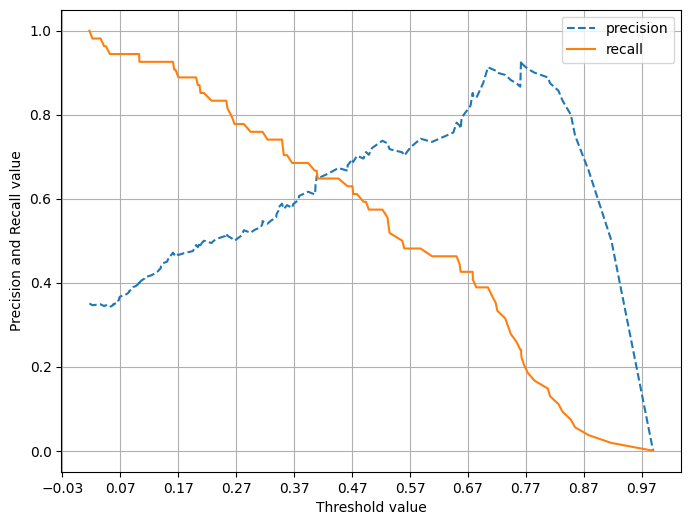

In [14]:
# 임계값별 정밀도-재현율 출력
pred_proba_c1 = lr_clf.predict_proba(X_test)[:, 1]
precision_recall_curve_plot(y_test, pred_proba_c1)

임곗값=0.42에서 정밀도와 재현율의 균형을 맞출 수 있는 것으로 파악됨

다만, 정밀도, 재현율 지표 모두 0.7보다 낮은 수치로 나타나고 있음 

데이터를 확인하여 개선할 부분이 있는지 확인 필요

In [15]:
diabetes_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


min() = 0 인 featre 존재(Glucose, BloodPressure, SkinThickness, Insulin, BMI)

각 feature는 사람이라면 0이라는 수치를 보일 수 없음 

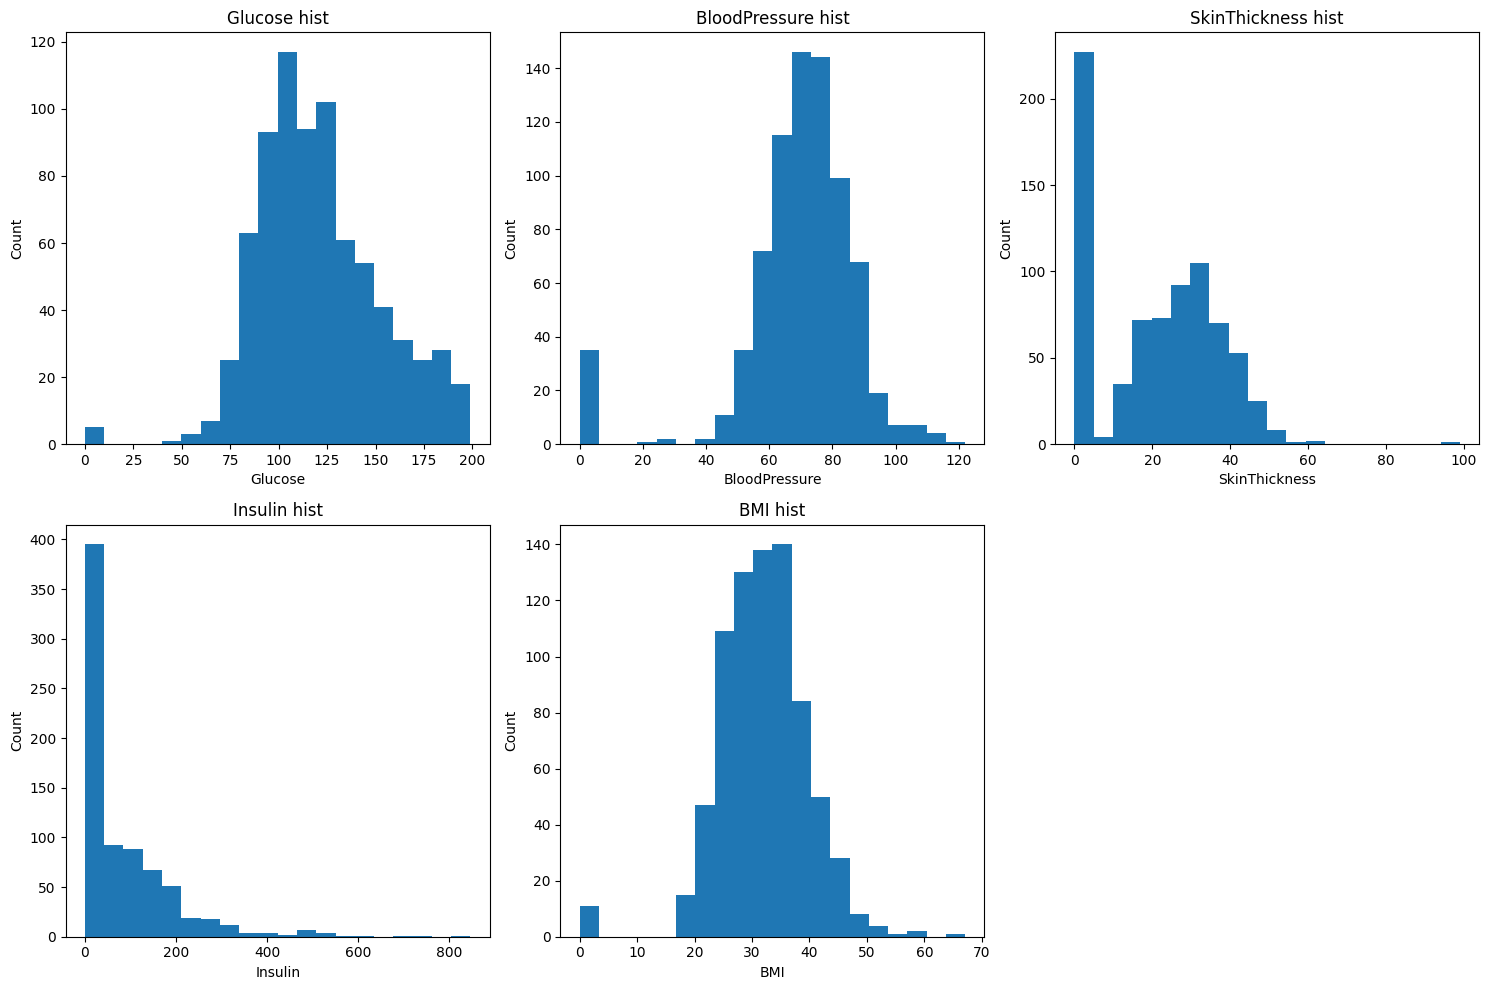

,Count,Percent(%)
Glucose,5.0,0.65
BloodPressure,35.0,4.56
SkinThickness,227.0,29.56
Insulin,374.0,48.70
BMI,11.0,1.43


In [16]:
zero_feature = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

fig, axes = plt.subplots(2, 3, figsize=(15,10))
axes = axes.ravel()

total_count = diabetes_data['Glucose'].count()
zero_count = []
zero_percent = []

for i, feature in enumerate(zero_feature):
    axes[i].hist(diabetes_data[feature], bins=20)
    axes[i].set_title(f"{feature} hist")
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("Count")
    
for feature in zero_feature:    
    zero_num = diabetes_data[diabetes_data[feature] == 0][feature].count()
    zero_count.append(zero_num)
    zero_percent.append(np.round(zero_num/diabetes_data.shape[0]*100, 2))
    # plt.figure()
    # plt.hist(diabetes_data[feature], bins=20)
    # plt.title(f"{feature} hist")
    # plt.xlabel(feature)
    # plt.ylabel("Count")

    # zero_count = diabetes_data[diabetes_data[feature] == 0][feature].count()
    # zero_percent = zero_count/total_count*100
    # print(f"{feature} 특잇값 건수:{zero_count}, 비중:{100*zero_count/total_count:.2f}%")


axes[-1].axis('off')

plt.tight_layout()
plt.show()

zero = pd.DataFrame([zero_count, zero_percent], columns=zero_feature, index=['Count', 'Percent(%)']).T
zero

SkinThickness, Insulin 각각 29.56%, 48.7%가 0의 값을 가짐 

zero_feature에 해당하는 데이터들을 평균값으로 대체하여 진행 

In [17]:
# 특잇값 변환
mean_zero_features = diabetes_data[zero_feature].mean()
diabetes_data[zero_feature] = diabetes_data[zero_feature].replace(0, mean_zero_features)

In [18]:
# 데이터 전처리 후 Logistic Regression 재실행
X = diabetes_data.iloc[:, :-1]
y = diabetes_data.iloc[:, -1]

# StandardScaler 적용
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=156, stratify=y)

In [19]:
# Logistic Regression
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, pred)

오차 행렬
[[90 10]
 [21 33]]
정확도:0.7987, 정밀도:0.7674, 재현율:0.6111, F1:0.6804, AUC:0.7556


데이터 변환과 스케일링을 통해 일정 수준 성능 수치 개선된 것을 확인 

재현율에 대한 개선 진행 필요 

<이전 결과>

오차 행렬

[[88 12]

 [23 31]]
 
정확도:0.7727, 정밀도:0.7209, 재현율:0.5741, F1:0.6392, AUC:0.7270

In [20]:
# 성능평가 값 재산출
thresholds = [0.3, 0.33, 0.36, 0.39, 0.42, 0.45, 0.48, 0.50]

pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1, 1), thresholds)

임곗값: 0.3
오차 행렬
[[67 33]
 [11 43]]
정확도:0.7143, 정밀도:0.5658, 재현율:0.7963, F1:0.6615, AUC:0.7331
임곗값: 0.33
오차 행렬
[[72 28]
 [12 42]]
정확도:0.7403, 정밀도:0.6000, 재현율:0.7778, F1:0.6774, AUC:0.7489
임곗값: 0.36
오차 행렬
[[76 24]
 [15 39]]
정확도:0.7468, 정밀도:0.6190, 재현율:0.7222, F1:0.6667, AUC:0.7411
임곗값: 0.39
오차 행렬
[[78 22]
 [16 38]]
정확도:0.7532, 정밀도:0.6333, 재현율:0.7037, F1:0.6667, AUC:0.7419
임곗값: 0.42
오차 행렬
[[84 16]
 [18 36]]
정확도:0.7792, 정밀도:0.6923, 재현율:0.6667, F1:0.6792, AUC:0.7533
임곗값: 0.45
오차 행렬
[[85 15]
 [18 36]]
정확도:0.7857, 정밀도:0.7059, 재현율:0.6667, F1:0.6857, AUC:0.7583
임곗값: 0.48
오차 행렬
[[88 12]
 [19 35]]
정확도:0.7987, 정밀도:0.7447, 재현율:0.6481, F1:0.6931, AUC:0.7641
임곗값: 0.5
오차 행렬
[[90 10]
 [21 33]]
정확도:0.7987, 정밀도:0.7674, 재현율:0.6111, F1:0.6804, AUC:0.7556


임계값이 0.48일 때 전체적인 성능 평가 지표를 유지하면서 재현율을 약간 향상됨 

In [21]:
binarizer = Binarizer(threshold=0.48)

pred_th_048 = binarizer.fit_transform(pred_proba[:, 1].reshape(-1, 1))

get_clf_eval(y_test, pred_th_048)

오차 행렬
[[88 12]
 [19 35]]
정확도:0.7987, 정밀도:0.7447, 재현율:0.6481, F1:0.6931, AUC:0.7641
